In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
nbdir = "/content/gdrive/My Drive/DSCI691/final/01-association/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/My\ Drive/DSCI691/final/01-association/

/content/gdrive/My Drive/DSCI691/01-association


# DSCI 691: Natural language processing with deep learning <br> Chapter 1: Association, variation, and statistical context models

## 1.0 Patterns in text streams

An important first question that every NLP-DL engineer should ask is:

> What kinds of machine-learnable information exist in text streams?

We'll encounter different specifications of this question through _tasks_, or, outcomes that an engineer's system must fulfill. However, whether they're fulfilled by modeling long- or short-range correlations in text data, NLP _with DL_ almost exclusively derives it's knowledge of language from associations between text symbols at different scales. So, we'll take some time in this first section to review some of the different kinds of learning information that text can offer and how its extraction forms an immediate challenge to the basis of any DL system.

## 1.1 Frequency-based resoning
Starting with single-document analysis, this chapter will introduce the subject through discussion of multi-scale (sentence and word) segmentation, and introduce entropy and scale free (power-law) variation.

#### 1.1.0.0 Source data: a Digital News Network (DNN)

In this chapter, we'll be working with a sample from a research dataset called _NewsTweet_. This data set follows Google's RSS feed of news articles and accesses and pre-processes them, and as an additional enrichment of the data with social media, accesses and includes embedded social media content. For more details on the NewsTweet project, see this paper: 

- https://arxiv.org/pdf/2008.02870.pdf

Our exploration will maily focus on properties of text-based here, but there's a wealth of information within the DNN's underlying Google's feed, which we might think of as a network of online news sites over which information (i.e., news content) flows. 

In [ ]:
import json
import random as ra
newstweet = json.load(open('./data/newstweet-subsample-linked.json'))
newstweet[0]

{'authors': [],
 'spans': [],
 'text': "AEW star Matt Jackson of The Young Bucks is currently dealing with a partially torn MCL and thinning of the ACL, which is also considered a slight tear.\n\nThe injury is why Jackson has been selling an injury as of late, according to Bryan Alvarez of Wrestling Observer Radio.\n\nJackson suffered the injury back on July 22 during the Falls Count Anywhere match between The Bucks and The Butcher & The Blade on AEW Dynamite. The injury reportedly occurred at the end of the match when The Bucks hit the flying elbow drops from the top of the set, onto their opponents down below, who were laying on top of tables. It was noted that the table leg jammed up Jackson's knee. Jackson delivered his elbow drop to The Butcher.\n\nJackson has been rehabbing the injury ever since then, apparently avoiding surgery. The Bucks have worked 8 matches since the injury occurred.\n\nThe Young Bucks are set to challenge AEW World Tag Team Champions FTR at Saturday's Full G

### 1.1.1 Segmentation
To even begin discussing where the statistical information in text comes from, we have to immediately begin considering the units we wish to measure the statistics of. Hence, _segmentation_ (not just of words) should be a consideration we always come back to when we work on language processing models.

#### 1.1.1.1 Tokenization into types
No scale of segmentation is likely a better starting point for language processing work than the word-focused task of tokenizing _types_, which are most intuitively understood as unique 'word' forms. Here, a long standing bias towards ASCII characters and the languages they support might instill the perspective that intuitive delimiters (e.g., separation by space, punctuation etc.) suffice to for all tokenization needs (this is not true). So while we'll often use this simple mechanism (including across this chapter), it's essential not to fall into the assumption that our basic tokenization utilities will always be ideal, even when scalabiliy constraints force us to make these tools suffice.

Below is a simple tokenization function that works pretty well on English text. How would you modify this to utilize the non-delimiting characters of other languages?

In [ ]:
import re
def tokenize(text, space = True):
    tokens = []
    for token in re.split("([0-9a-zA-Z'-]+)", text):
        if not space:
            token = re.sub("[ ]+", "", token)
        if not token:
            continue
        if re.search("[0-9a-zA-Z'-]", token):                    
            tokens.append(token)
        else: 
            tokens.extend(token)
    return tokens

print(tokenize(newstweet[0]['title']))

['Matt', ' ', 'Jackson', ' ', 'Of', ' ', 'The', ' ', 'Young', ' ', 'Bucks', ' ', 'Reportedly', ' ', 'Injured', ' ', 'Going', ' ', 'Into', ' ', 'AEW', ' ', 'Full', ' ', 'Gear']


#### 1.1.1.2 Tokenization into sentences
Eventually, we'll need some more fine-grained document structure, so it's important to have some facility for higher-level linguistic units, such as sentences. Here's an example sentence tokenizer that utilize a positive lookbehind pattern to capture sentence delimiters and filter out abbreviations and decimal numbers (hopefully). Can you break the `sentokenizer`?

In [ ]:
def sentokenize(text, space = True):
    sentences = []
    for sentence in re.split("(\s+(?<=[.?!,;:\n][^a-zA-Z0-9])\s*)", text):
        if (len(sentence)==1 and not re.search("[0-9a-zA-Z'-]", sentence[0])):
            if len(sentences):
                sentences[-1] = sentences[-1] + [sentence]  
            else:
                sentences.append([sentence])
        elif not re.search("[0-9a-zA-Z'-]", sentence):
            tokens = tokenize(sentence, space = space)
            if len(sentences):
                sentences[-1] = sentences[-1] + tokens  
            else:
                sentences.append(tokens)
        else:
            sentences.append(tokenize(sentence, space = space))
    return sentences

In [ ]:
sentences = sentokenize(newstweet[0]['text'])
print(sentences[0])

['AEW', ' ', 'star', ' ', 'Matt', ' ', 'Jackson', ' ', 'of', ' ', 'The', ' ', 'Young', ' ', 'Bucks', ' ', 'is', ' ', 'currently', ' ', 'dealing', ' ', 'with', ' ', 'a', ' ', 'partially', ' ', 'torn', ' ', 'MCL', ' ', 'and', ' ', 'thinning', ' ', 'of', ' ', 'the', ' ', 'ACL', ',', ' ']


### 1.1.2 Frequency and Type
Tokenization is our basic utility for determining _where_ the things are that we wish to analyze statistically, but here we'll have to confront the question of _which_ of these things are the same. Hence, the act of counting, i.e., computing token _frequencies_ boils down to determining what makes two tokens the same _type_. For example, should we lowercase? Aggregate matching strings according to part of speech? 

Regardless, after we complete our decision making about how to represent type, we wind up with a set (vocabulary) of types, $W$, and for each token $t\in W$ our goal will be to determine its number of occurrences, i.e., its frequency:

$$
f(t) = \text{number of times $t$ appears as a token}
$$

#### 1.1.2.1 Computing Frequency
While the above questions can often pin down the finer details of a token's linguistic function, the basic statistics of tokens are surprisingly stable and many of the quantitative tricks we run into throughout the course root back to these distributions. Working along the lines of efficiency, let's move forward with a simple lowercase strategy to typing tokens. Counting itself is an relatively easy process to program, and for the most part we'll just use its abstraction via the `Counter` object, which is essentially a python dictionary that defaults to integer 0 and has built in sorting functions:

In [ ]:
from collections import Counter
counts = Counter([t for s in sentences for t in s])
print(counts.most_common(25))

[(' ', 232), ('the', 13), ('.', 12), ('The', 11), ('\n', 10), ('of', 8), (',', 8), ('injury', 7), ('Bucks', 6), ('Jackson', 5), ('to', 5), ('on', 5), ('AEW', 4), ('is', 4), ('a', 4), ('and', 3), ('been', 3), ('match', 3), ('FTR', 3), ('be', 3), ('for', 3), ('Young', 2), ('which', 2), ('has', 2), ('as', 2)]


#### 1.1.2.2 Vectorization
To utilize calculated frequency we'll most often have to first convert our data to a vectorized/linear algebraic object type, i.e., a tensor or array. When we do this, we'll then have to begin keeping track of type indices.

In [ ]:
import numpy as np
types, f = map(np.array, zip(*counts.most_common()))
type_index = {t:i for t, i in enumerate(types)}
f[:10]

array([232,  13,  12,  11,  10,   8,   8,   7,   6,   5])

Putting all of this together, it's useful to have document frequency function:

In [ ]:
def freq(text, space = True):
    sentences = sentokenize(text, space = space)
    counts = Counter([t for s in sentences for t in s])
    types, f = map(np.array, zip(*counts.most_common()))
    type_index = {t:i for t, i in enumerate(types)}
    return f, type_index

In [ ]:
f, type_index = freq(newstweet[0]['text'].lower())

#### 1.1.2.3 Rank-frequency statistics
Since we extracted an array of the frequencies here in high-to-low (sorted) order (via `.most_common()`), the values of our `word_index` are actually now one less than the words' _ranks_. For these ranks-by-frequency, we'll intuitively have: 
$$
r_t=1 \Rightarrow f(t) = \max_W\{f\}
$$
i.e., so that $r_s=2$ means $s$ is the second-most-common word. But a perhaps surprising regularity exists between $f$ and $r$ under this arrangement (when space, i.e., `" "`, is excluded), known as Zipf's Law:
$$
f(t)\approx C\cdot r_t^{-1}
$$
where the exponent might vary, but is (for single documents) quite close to $-1$.


[If space is included](https://arxiv.org/pdf/1710.07729.pdf) in the rank-frequency picture, the relationship is perhaps partly explained in a generative way by [Simon's model](http://arxiv.org/pdf/2008.02885.pdf):
$$
f(t)\approx C\cdot (r_t - \theta)^{-\theta}
$$
which approximates frequency pretty well via a probabilistic value, $\theta\in[0,1]$, when $\theta\approx 1$ (for English a large number of human languages, at least). However, this functional relationship between rank and frequency is neither exact nor entirely well understood. So it's best to draw from this the following takeaway:
- some words appear much more frequently than others and most words appear once.

This has recurring effects on how we have to sample from, and ultimately, standardize (which we'll discuss next) frequency-based data, e.g., as it may not be the most valuable strategy to build models that work from the 'uninteresting' statistics of high-frequency 'stop words', like `'the'`. Here's what Zipf's law (ordered frequency) looks like for a single document:



In [ ]:
import matplotlib.pyplot as plt

def plot_frequency(f, space = True):
    r = np.array(range(1, len(f)+1))
    
    if space:
        t = (1 - r/f.cumsum()).mean()
        fhat = (r - t)**-t
        model_name = "Simon's model " + "($\\theta ="+str(round(t, 2))+")$"
    else:
        fhat = 1/r
        model_name = "Zipf's Law"

    fig = plt.figure(figsize = (6,6))
    plt.plot(np.log10(r), np.log10(f), color = 'black', lw = 3, label = "Data")
    plt.plot(np.log10(r), np.log10(fhat) - np.log10(fhat[0]) + np.log10(f)[0],
             color = 'red', lw = 3, linestyle = 'dashed', label = model_name)
    plt.tick_params(labelsize = 15)
    plt.title("Rank vs. frequency", fontsize = 15)
    plt.ylabel("$\log_{10}f$", fontsize = 15)
    plt.xlabel("$\log_{10}r$", fontsize = 15)
    _ = plt.legend(fontsize = 15)

Plotted in log-log scale, when space is excluded, this just looks like a straight, decreasing line of slope near $-1$:

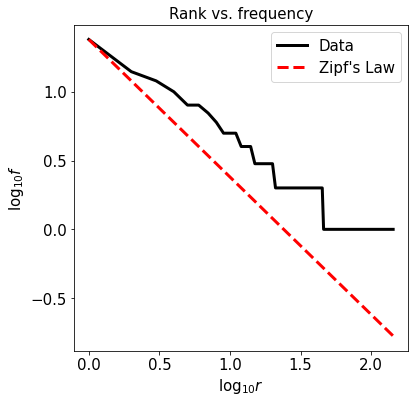

In [ ]:
space = False
f, type_index = freq(newstweet[0]['text'].lower(), space = space)
plot_frequency(f, space = space)

However, the frequency of space is an outlier in the distributional shape, which will result in the model accomodating with a more-severe scaling exponent:

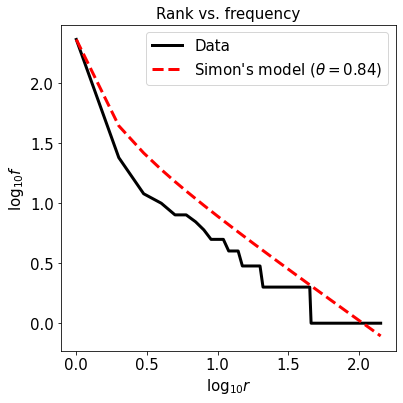

In [ ]:
space = True
f, type_index = freq(newstweet[0]['text'].lower(), space = space)
plot_frequency(f)

## 1.2 Document-level variation
So far, we've only just begun exploring text-based statistical variation in the context of frequency. Zipf's law (above) is something that is most-tightly observed for reasonably independent and complete chunks of text, which we might think of as _documents_. Fortunately, a lot of document-level structure is often provided to us during text-data acquisition processes. For example, our data source in this Chapter (NewsTweet) comes to us with separate articles that we might just already think of as documents, and this separation of documents is provided by the separation and indexing of content by writers and editors on different web pages.
### 1.2.3 Frequencies of types across documents
So far, we've just looked at count-based frequency and single-document vectorization. The most basic representation type for multiple documents essentially just extends these principles. To set things up, suppose we have $m$ documents, $d_1, \cdots, d_m$, from some set $D$ and that for each document we have measured its word frequencies are recorded as $f(t, d_j)$. Next we have to ask: how can we put all of this information together in a convenient way?

#### 1.2.3.1 Term document matrices (TDMs)
To build a matrix of word frequencies that spans multiple documents we'll need to come up with a master index of all of the words spanning the documents. This means establishing a global ordering: $t_1, \cdots, t_n$, assuming $n$ is the number of types which appear across all $m$ documents. Finally, for most applications, including the below we assume that documents are normalized, i.e., each column's values are divided by their sum:
$$
p(t_{i}, d_{j}) = \frac{f(t_{i}, d_{j})}{\sum_{k = 1}^n f(t_{k}, d_{j})}
$$

to produce what is often referred to as its bag-of-words (BOW) probabilities. With this, we can define our TDM as the matrix of probabilistic columns:

$$
TDM = 
\begin{bmatrix}
    p(t_{1}, d_{1}) & p(t_{1}, d_{2}) & \dots  & p(t_{1}, d_{m}) \\
    p(t_{2}, d_{1}) & p(t_{2}, d_{2}) & \dots  & p(t_{2}, d_{m}) \\
    \vdots           & \vdots           & \ddots & \vdots \\
    p(t_{n}, d_{1}) & p(t_{n}, d_{2}) & \dots  & p(t_{n}, d_{m})
\end{bmatrix},
$$

#### 1.2.4 Frequency of appearance across documents
TDMs provide a powerful quantitative framework through which to view text. One important concept introduced by the TDM is the notion of a _corpus_ or collection of documents. This offers a basis for comparison, and better featurization of documents. Many examples use a variant of frequency called _term frequency-inverse document frequency (TF-IDF)_. TF-IDF still uses the probabilistic CBOW frequencies of words in documents, but will use them in conjunction with other, document-level information&mdash;specifically the frequency of documents containing a word, or, _document frequency_:

- $F(t\mid D) = $ number of documents $d$ in the collection $D$ containing $t$.

Words like `'the'`, etc., will generally occur across most or all documents, i.e., with $D\approx m$. The motivation behind _inverse_ document frequency is that boring words will appear like this, distributed widely/uniformly across all documents. Thus, an inverse document frequency will reduce the feature-importance of such words. 

#### 1.2.4.1 Inverse document frequency
What we're going to do is wind up with a measure that says _how surprising_ it is to see _this_ word appear in _that_ document $k$ times_. The standard TF-IDF procedure goes beyond inversion of document frequency and into a measurement of word-information density.  [Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) does a good job laying out an intuitive justification:

> The inverse document frequency is a measure of how much information the word provides, that is, whether the term is common or rare across all documents. It is the logarithmically scaled inverse fraction of the documents that contain the word, obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient.

In other words, the quantity known as IDF is actually the negative logarithm of the portion of documents that contain a word:

$$
H(t\mid D) = 
-\log_2 \frac{F(t\mid D)}{m} =
-\log_2 q(t\mid D)
,$$

where $q(t\mid D) = \frac{F(t\mid D)}{m}$ is that said portion.


#### 1.2.4.2 Aside: why take the negative logarithm? 
In general, the negative logarithm of a probability is a measure called _entropy_. In some circles, this quantity is called _information_, and in others it is called _suprise_! Let's stick to calling it entropy or suprise, and try to think of it intuitively as _the smallest number of bits, i.e., $0$s and $1$s one would need to set aside to ensure there is a unique pattern&mdash;a binary encoding&mdash; for each word._

This can be seen directly, because any probability, $p$, can be represented as a (negative) power of $2$, i.e., there exists some $b\geq0$ such that $p = 2^{-b}$. As it turns out, $2^b$ is the number of possible $b$-bit selections (with replacement) from the two states of a bit: $0$ or $1$. Thus, we can interpret $p$ as one binary pattern of $0$s and $1$s from $b$ bits. With this representation we can see:

$$-\log_2(p) = -\log_2(2^{-b}) = b,$$

i.e., the logarithm produces $b$, the number of bits.

#### 1.2.4.3 TF-IDF
Putting together our measures of in-document and across-documents frequencies, we can now compute TF-IDF by-word-and-document as:

$$
\begin{align}
h(t, d_{j}\mid D) & = p(t, d_{j})H(t\mid D) \\
& = -p(t, d_{i})\log_2 q(t\mid D) \\
& = -\log_2 q(t\mid D)^{p(t, d_{j})}
\end{align}
$$

and store them in the same format as our $TDM$s.

#### 1.2.4.4 Interpreting TF-IDF
While we might compute TF-IDF according to the top expression, it's important to come away with thinking of it in terms of the bottom expression. This is a probability to a power! Basically, this probability (to a power) can be viewed under an independence assumption as:

- the probability that $t$ appears in a document $p(t_{j}, d_{j})$-of the time, given $D$.

But that actually means that tfidf _is_ an entropy/suprise framing in its own right, answering the question:

> How surprising is it to see $t$ from a $D$-document $p(t, d_{j})$-of the time?

Regardless, $h(t,d_{i}\mid D)$ produces non-zero, and hence, _normalizable_ weights can be used as statistical features, much like simple document frequency. But as we'll see, TF-IDF often has enhanced predictive power over simple document frequency.

#### 1.2.4.5 Sample code for computing TDMs and TF-IDF
The below should provide some robust utility for computing TDMs and TF-IDF for an list of strings (`documents`)

In [ ]:
import scipy as sp
import scipy.sparse
def make_TDM(documents, do_tfidf = True, space = True, normalize = True):
    document_frequency = Counter()
    for j, document in enumerate(documents):
        frequency = Counter([t for s in sentokenize(document.lower(), space = space) 
                         for t in s])
        document_frequency += Counter(frequency.keys())
    type_index = {t:i for i, t in enumerate(sorted(list(document_frequency.keys())))}
    document_frequency = np.array(list(document_frequency.values()))
    # performs the counting again, and stores with standardized indexing`
    counts, row_ind, col_ind = map(np.array, zip(*[(count, type_index[t],j) 
                                                   for j, document in enumerate(documents) 
                                                   for t, count in Counter(tokenize(document.lower(), space = space)).items()]))
    # constructs a sparse TDM from the indexed counts
    TDM = sp.sparse.csr_matrix((counts, (row_ind, col_ind)),
                             shape = (len(document_frequency),len(documents)))
    if normalize:
        # normalize frequency to be probabilistic
        TDM = TDM.multiply(1/TDM.sum(axis = 0))
    # apply tf-idf
    if do_tfidf:
        num_docs = TDM.shape[1]
        IDF = -np.log2(document_frequency/num_docs)
        TDM = (TDM.T.multiply(IDF)).T
    return(TDM, type_index)

### 1.2.5 A document-level prediction problem
Converting the `'tweet'` field of our articles to a boolean, suppose we wanted to try and detect whether a news article has&mdash;or looks like it should have&mdash;a tweet embedded as a point of reference. Our simple-frequency TDM or TFIDF matrices can be used as features in a simple, e.g., Logistic Regression classifier model. The below code explores this idea and computes accuracy for each case&mdash;TFIDF, and simple probabilistic frequency. While this might not be the most informative task, it will let us observe the increased predictive power of TFIDF for document-level prediction tasks, such as SPAM detection.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

def eval_tweet_prediction(TDM, newstweet, state = 0):
    y = np.array([int(bool(x['tweets'])) for x in newstweet])
    x = TDM.T
    x_train, x_test_holdout, y_train, y_test_holdout = train_test_split(x, y, test_size=0.33, random_state=state)

    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.67, random_state=state)

    classifier = LogisticRegression(solver='liblinear', random_state = state)
    classifier.fit(x_train, y_train)
    prediction_probabilities = classifier.predict_proba(x_test)

    max_F1 = 0
    max_ix = 0
    max_threshold = 0
    for ix, threshold in enumerate(np.array(range(1,1001))/1000):
        threshold_predictions = np.array([1 if prediction[1] > threshold else 0 
                                          for prediction in prediction_probabilities])
        TP = ((threshold_predictions == 1) & (y_test == 1)).astype(int).sum()
        FP = ((threshold_predictions == 1) & (y_test == 0)).astype(int).sum()
        TN = ((threshold_predictions == 0) & (y_test == 0)).astype(int).sum()
        FN = ((threshold_predictions == 0) & (y_test == 1)).astype(int).sum()
        P = TP/(TP + FP) if TP + FP else 0
        R = TP/(TP + FN) if TP + FN else 0
        F1 = ((2*P*R)/(P+R)) if P+R else 0
        if F1 > max_F1 and R != 1.0:
            max_F1 = F1
            max_ix = ix
            max_threshold = threshold

    holdout_predictions = classifier.predict_proba(x_test_holdout)
    threshold_predictions = np.array([1 if prediction[1] > max_threshold else 0 
                                    for prediction in holdout_predictions])
    TP = ((threshold_predictions == 1) & (y_test_holdout == 1)).astype(int).sum()
    FP = ((threshold_predictions == 1) & (y_test_holdout == 0)).astype(int).sum()
    TN = ((threshold_predictions == 0) & (y_test_holdout == 0)).astype(int).sum()
    FN = ((threshold_predictions == 0) & (y_test_holdout == 1)).astype(int).sum()
    P = TP/(TP + FP) if TP + FP else 0
    R = TP/(TP + FN) if TP + FN else 0
    F1 = ((2*P*R)/(P+R)) if P+R else 0

    return Counter({"P": P, "R": R, "F1": F1}), classifier, max_threshold

Probabilistic results without TF-IDF show low precision:

In [ ]:
from functools import reduce
do_tfidf = False; space = False
print('building TDM...')
TDM, type_index = make_TDM([x['text'] for x in newstweet], 
                           do_tfidf = do_tfidf, space = space)
num_states = 30
results = [eval_tweet_prediction(TDM, newstweet, state = i)[0] for i in range(num_states)]
print({k: v/num_states for k,v in reduce(lambda a,b: a+b, results).items()})

building TDM...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


{'P': 0.13464760485963229, 'R': 0.4984715353707479, 'F1': 0.1601693977747785}


The entropic stretching of TF-IDF supports discrimination, often boosting recall at less cost to precision:

In [ ]:
do_tfidf = True; space = False
print('building TDM...')
TDM, type_index = make_TDM([x['text'] for x in newstweet], 
                           do_tfidf = do_tfidf, space = space)
num_states = 30
results = [eval_tweet_prediction(TDM, newstweet, state = i)[0] for i in range(num_states)]
print({k: v/num_states for k,v in reduce(lambda a,b: a+b, results).items()})

building TDM...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


{'P': 0.12563337510586325, 'R': 0.3099744001754367, 'F1': 0.15782942606693692}


Without TF-IDF, ubiquitous terms, like space are harmful to the model's discriminatory ability:

In [ ]:
do_tfidf = False; space = True
print('building TDM...')
TDM, type_index = make_TDM([x['text'] for x in newstweet], 
                           do_tfidf = do_tfidf, space = space)
num_states = 30
results = [eval_tweet_prediction(TDM, newstweet, state = i)[0] for i in range(num_states)]
print({k: v/num_states for k,v in reduce(lambda a,b: a+b, results).items()})

building TDM...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


{'P': 0.09698993119120067, 'R': 0.4331703832055831, 'F1': 0.14983167681724638}


While including space with TF-IDF still comes at some cost, it does generally allow us to balance and integrate the high-frequency statistics, in general, without making assumptions about word sets, like stop words etc.:

In [ ]:
do_tfidf = True; space = True
print('building TDM...')
TDM, type_index = make_TDM([x['text'] for x in newstweet], 
                           do_tfidf = do_tfidf, space = space)
num_states = 30
results = [eval_tweet_prediction(TDM, newstweet, state = i)[0] for i in range(num_states)]
print({k: v/num_states for k,v in reduce(lambda a,b: a+b, results).items()})

building TDM...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


{'P': 0.10677109555557025, 'R': 0.35366309124237516, 'F1': 0.14189694124431182}


## 1.3 Localized variation
So far, our document level task has only utilized global variation and statistics of documents to information document-level predictions. While we won't delve into predicting local-level information here, we will begin to explore the information in localized variation. Here, by _local_ we mean the statistics of nearby tokens. How do we define nearby? That's where our `sentokenizer` comes in, i.e., from our secondary segmentation scale!
<!-- 
However, to 
- returns to text streams, computes sliding-window models
- builds co-ocurrence matrices
- discusses harmonic/entropic weighting schemes
- introduces text sampling
- explores cross-entropy rankings on one-word contexts -->

### 1.3.1 One-hot encoding
So far, our ability to represent each document through features depends on the entropic TF-IDF weights of tokens: $h(t, d_{j}\mid D)$. These are document-level _weights_, i.e., that tell us how much attention we should pay to each.

However, the _semantics_ of each token is currently something whose model we haven't discussed. In particular, our semantic model describes how we discern tokens, $t$, from one another, and neither document frequency nor TF-IDF do this, e.g., since two different types can have the same weight. Instead, we are presently only distinguishing each type as a distinct feature in our data set, which is equivalent to a linear represntation vocabulary-length ($|W|$) standard basis vectors, i.e., so if $t$'s (row) index is $i_t$ in the the TF-IDF TDM, we are technically utilizing the $|W|$-dimensional vector:
$$
\vec{e}_{t} =
\begin{cases} 
  1 & i = i_t \\
  0 & i \neq i_t
\end{cases}
$$

and informing any subsequent analysis by the weighted basis vector $h(t, d_{j}\mid D)\cdot\vec{e}_{t}$ for each given document. Doing so factors the assumed semantic uniqueness for each distinct type with it's document-level-importance weighting.

This is technically called the _one-hot encoding_ framework, which is _sparse_. This&mdash;sparse representation with a large dimensionality&mdash;is the framework's primary limitation, so generally we'll expand upon it by developing _dense_ representations with reduced (from $|W|$) dimensionality.

### 1.3.2 Context models
To get away from one-hot encoding and into a lower-dimensional space where types can continuously wind up 'near' one another, we need to condition the type statistics on one another. While there are many different frameworks for _context models_ that we could define, they are, generally, frequency-based statistical models of variation that often measure _co-ocurrence_, i.e., describe how often distinct types appear in the vicinity of one another.

#### 1.3.2.1 Sliding-window context
To start, let's view any sentence, $s$, as a sequence of tokens of length $L$: $s = \{t_i\}_{i=1}^L$. This sequence-size packaging into sentences is our base model of _localization_, from which we should build any 'ocurrs near' statistics. 

Using sentence-level localization, perhaps the simplest, most-commonly-used context model is called the _sliding window_ model and counts the co-ocurrence of types within a 'window' of size $\pm k$, for a fixed hyperparameter $k$. So, for our sentence, $s$, of length $L$, each type, $t_i$, appears in a _context_, $c(t_i,s;k)$, which is a subsequence of the tokens of $s$ that are $\leq k$ steps away from $t_i$ in the reading order. We can express this a bit more precisely as:
$$
c(t_i,s;k) = \{t_{i - k}, t_{i - (k-1)},\cdots, t_{i - 1}, t_{i + 1}, \cdots, t_{i + (k-1)}, t_{i + k} \}
$$

with the caveat that fewer tokens will be available when the center term, $t_i$, is near the boundaries of $s$, i.e., $c(t_i,s;k)$ will contain fewer than $2k$ tokens whenever $i + k > L$ or $i - k < 1$.

Under this definition, our context model is a joint-frequency distribution that counts the following information:
$$
f(t_i, t_j) = \text{number of times }t_j\text{ appeared within a window of size }2k\text{ centered on }t_i
$$

However, there is some question as to whether close vs. distant words within a given context window should be counted with the same _weight_. Thus, it is likewise a common hyperparametric approach to apply a power-law weighting to the co-ocurrences to smooth the analysis.
$$
w(t_i,s;k) = \left\{k^{-\gamma},(k-1)^{-\gamma},\cdots, 1, 1, \cdots, (k-1)^{-\gamma}, k^{-\gamma}\right\}
$$

In order to produce the co-ocurrence data (weighted and un-weighted), we'll have to construct a processor which provides the weighted combinations of words in their contexts, co-appearing words.

In [ ]:
def get_context(i, sentence, k = 20, gamma = 0):
    context = np.array(sentence)
    weights = np.abs(np.array(range(len(sentence))) - i)
    mask = (weights != 0) & (weights <= k) if k else (weights != 0)
    context = context[mask]
    weights = 1/(weights[mask]**gamma) if gamma else weights[mask]*gamma + 1.
    return context, weights

In [ ]:
sentences = sentokenize(newstweet[0]['text'])
print(get_context(6, sentences[0], 3, 1))

(array([' ', 'Matt', ' ', ' ', 'of', ' '], dtype='<U9'), array([0.33333333, 0.5       , 1.        , 1.        , 0.5       ,
       0.33333333]))


#### 1.3.2.1 Co-ocurrence matrices
Since we've already see a TF-IDF construction, it's not too surprising to see how a full Co-occurrence matrix (CoM) is constructed. 

Like with the TDM we _can_ also assume that contexts be normalized, i.e., have each column's values divided again by their sum:
$$
p(t_{i}, t_{j}) = \frac{f(t_{i}, t_{j})}{\sum_{k = 1}^{n} f(t_{k}, t_{j})}
$$

to produce different bag-of-words (BOW) probabilities. However, there is some concern in normalizing a co-occurrence matrix by context in that the contexts are lacking the representation of totality that the _documents_ of a TDM do. Regardless, with our normalization the procedure for defining our CoM, we have:

$$
CoM = 
\begin{bmatrix}
    p(t_{1}, t_{1}) & p(t_{1}, t_{2}) & \dots  & p(t_{1}, t_{n}) \\
    p(t_{2}, t_{1}) & p(t_{2}, t_{2}) & \dots  & p(t_{2}, t_{n}) \\
    \vdots           & \vdots           & \ddots & \vdots \\
    p(t_{n}, t_{1}) & p(t_{n}, t_{2}) & \dots  & p(t_{n}, t_{n})
\end{bmatrix},
$$

Likewise, we can even perform an analgously entropic TF-ICF transformation to scale the data. Comparing this to our one-hot-encoding, each type now has an alternative semantic representation that describes its relationships of ocurrence to other types:
$$
\vec{p}_t = \left[p(t, t_{1}), p(t, t_{2}), \dots,  p(t, t_{n})\right]
$$

However, it's essentail to note that the increased scale of this matrix's complexity. Here, the CoM goes _way_ beyond the TDM's column space to a dimensionality up to $|W| \times |W|$! So in order to utilize this kind of variation, sparse calculations will be essential, in addition to _dimensionality reduction_.

In [ ]:
def make_CoM(documents, k = 20, gamma = 0, space = True, do_tficf = True, normalize = True):
    document_frequency = Counter()
    for j, document in enumerate(documents):
        sentences = sentokenize(document.lower(), space = space)
        documents[j] = sentences
        frequency = Counter([t for s in documents[j] for t in s])
        document_frequency += Counter(frequency.keys())
    type_index = {t:i for i, t in enumerate(sorted(list(document_frequency.keys())))}

    co_counts = Counter()  
    for document in documents:
        for sentence in document:
            for i, ti in enumerate(sentence):
                context, weights = get_context(i, sentence, k = k, gamma = gamma)        
                for j, tj in enumerate(context):
                    co_counts[(type_index[ti], type_index[tj])] += weights[j]

    type_ijs, counts = zip(*co_counts.items())
    row_ind, col_ind = zip(*type_ijs)

    # constructs a sparse CoM from the indexed counts
    CoM = sp.sparse.csr_matrix((counts, (row_ind, col_ind)),
                              shape = (len(type_index),len(type_index)))
    if normalize:
        # normalize frequency to be probabilistic
        CoM = CoM.multiply(1/CoM.sum(axis = 0))
    
    # apply tf-icf
    if do_tficf:
        context_frequency = np.count_nonzero(CoM.toarray(), axis=1)
        num_cons = CoM.shape[1]
        ICF = -np.log2(context_frequency/num_cons)
        CoM = (CoM.T.multiply(ICF)).T
        
    return CoM, type_index

In [ ]:
k = 5; space = False; gamma = 1
print('building CoM...')
CoM, type_index = make_CoM([x['text'] for x in newstweet], 
                           k = k, gamma = gamma, space = space)

CoM, type_index = make_CoM([x['text'] for x in newstweet])
type(CoM), CoM.shape

building CoM...


(scipy.sparse.coo.coo_matrix, (31980, 31980))

### 1.3.3 Combinatorality constraints and dimensionality reduction
Now it's great we've been able to model all of this variation in frequency, but the combinatorality of our approach scales impactically. Square matrices of size $>10,000$ hold $.1$-Billion values (model parameters), and as we will see below, if we want to compare the types for even this relatively-small data set, we'll have to reduce the CoM's rows in dimensionality.

#### 1.3.3.4 Singular-value decomposition (SVD) truncation
Recall the matrix-decomposition method known as SVD. [Paraphrasing Wikipedia](https://en.wikipedia.org/wiki/Singular_value_decomposition), we can understand its capacity as a dimensionality-reduction algorithm via the following:

> The singular value decomposition of an $m \times n$ real-valued matrix $X$ is a factorization of the form 
> $$X = U\Sigma V,$$ 
> where $U$ is an $m\times m$ real matrix, 
> $\mathbf{\Sigma}$ is an $m\times n$ rectangular diagonal matrix with non-negative real numbers on the diagonal (singular values), 
> and $V$ is an $n\times n$ matrix, such that $U$ and 
> ${V^{T}}$ are real orthogonal.

Provided the singular values from $\Sigma$ are sorted, the representation is unique, and this is what is done in practice. 

However, the utility for us with this decomposition is its function as a _dimensionality-reduction algorithm_. In particular, supposing we remove all but the $d$ first/largest singular values from $\Sigma$, and call this $\Sigma_d$, we can form a partial reconstruction of $X$ via:
$$
X_d = U\Sigma_d V
$$

which retains just the variance in $X$ represented by the first $d$ singular vectors, which for this decomposition, are a generalization of eigenvectors. In principle, the columns of $X_d$ no longer have interpretable units, e.g., in our application they will no longer co-ocurrence frequency, etc., but instead will provide a dense, linear-algebraic 'smearing' of $X$'s co-ocurrence variation, across types.

But practically, this allows us to access $d< |W|$-dimensional approximations of the variation expressed by the full CoM matrix, but which retains only the most $d$-important variation, provided by the decomposition.

In [ ]:
from sklearn.decomposition import TruncatedSVD

def svdsub(X, d=50):
    return TruncatedSVD(n_components=d).fit_transform(X)

As a guess, let's set a $d=50$-dimensional reduction as the default for our CoM.

In [ ]:
CoM_d = svdsub(CoM)

#### 1.3.3.4 Interpreting CoM statistics
Now we can finally apply a cosine-similarity comparer that accepts a token to find the most-similar others, i.e., produce a list of tuples of highest cosine similarity. Note that if we choose larger values of $d$, the similarity calculations become intolerably slow. However, do the model similarities seem sensible? Do they become more-sensible for larger values of $d$?

In [ ]:
def most_similar(t, type_index, X, top=10):
    vec = X / np.linalg.norm(X, axis=1)[:, np.newaxis]
    v = vec[type_index[t],:]
    similar = sorted(enumerate(list(vec.dot(v))), 
                     key = lambda x: x[1], reverse = True)
    types = list(type_index.keys())
    if not top: top = int(vec.shape[0])
    sims = [(types[ix], sim) for ix, sim in similar[:top] if ix != type_index[t]]
    return sims

Using the column-normalized vectors here is problematic, as we are comparing _rows_:

In [ ]:
most_similar('wrote', type_index, CoM_d, top=10)

[('sherrilyn', 0.9862292838990161),
 ('ifill', 0.9862193524772787),
 ('\u200f', 0.9862184012180266),
 ('rocker', 0.9594748821391237),
 ('contents', 0.809931853221129),
 ("washington's", 0.8018383799741887),
 ('biography', 0.7229502670592198),
 ('dunham', 0.7110077607476128),
 ('ventriloquists', 0.7110077245580819)]

Re-processing our CoM to be non-probabilistic (even while retaining ICF), immediately allows us to recover the type-type semantic connections:

In [ ]:
k = 5; space = False; gamma = 1
print('building CoM...')
CoM, type_index = make_CoM([x['text'] for x in newstweet], 
                           k = k, gamma = gamma, space = space, normalize = False)
CoM_d = svdsub(CoM)

building CoM...


In [ ]:
most_similar('wrote', type_index, CoM_d, top=10)

[('said', 0.9638870736117847),
 ('explained', 0.9311405074830338),
 ('added', 0.9024939949324361),
 ('iii', 0.8996398394086166),
 ('joked', 0.892639419469131),
 ('says', 0.8914275375715253),
 ('stated', 0.8895871041405926),
 ('recalled', 0.8886702357497923),
 ('alone', 0.8852059237707789)]

We can likewise see this through other complex meanings, like `'they'`:

In [ ]:
most_similar('they', type_index, CoM_d, top=10)

[('we', 0.9252443284855518),
 ('you', 0.8848161201002858),
 ('investors', 0.8587706802069351),
 ('fans', 0.8326107354187214),
 ('democrats', 0.8221726180370001),
 ('scientists', 0.7959755292315419),
 ('not', 0.792762014455671),
 ('even', 0.7903109846195542),
 ('experts', 0.7893968491448257)]

and in addtion find clear semantic connections amongst same parts of speech, like pronouns:

In [ ]:
most_similar('she', type_index, CoM_d, top=10)

[('he', 0.9677951084739019),
 ('kravitz', 0.8689313494744557),
 ('rodriguez', 0.8613914525219093),
 ('lafleur', 0.8545494321538595),
 ('alaphilippe', 0.8535311883067876),
 ('rodgers', 0.8511421637424555),
 ('byron', 0.846180689711031),
 ('stanley', 0.8427629082563854),
 ('graham', 0.8424840065733302)]

as well as via tense and conjugation:

In [ ]:
most_similar('understood', type_index, CoM_d, top=10)

[('claimed', 0.8790944763753797),
 ('caused', 0.877453195894241),
 ('adding', 0.8669850625185404),
 ('revealed', 0.8627344931047599),
 ('inequities', 0.8589897983166952),
 ('means', 0.8560559461982342),
 ('suggested', 0.8536030232750397),
 ('truth', 0.84610869294369),
 ('suggesting', 0.8460884080277683)]

## 1.4 Continuous Bag of Words (CBOW)
So, how can we fold together the TDM and CoM variation models to make better predictions? Another well-established baseline that seems to appear ubiquitously in model development is known as the CBOW model, which essentially just takes frequency (or TF-IDF) weighted sums of dense-representation vectrors. 
### 1.4.1 CBOW is the inner product of TDM and CoM
As it turns out, putting these models together is beautifully simple. While it will look different in different applications, the continuous document matrix (CDM) features we wish to compute are constructible by a simple inner product:
$$
CDM = \left[TDM^T\cdot CoM\right]^T
$$

where the resulting CDM matrix will be of dimensionality $d \times m$, i.e., have a column for each document featurized by $d$, TDM-weighted, semantically-summarized features (instead of the whole vocabulary of $n$).

In [ ]:
def cbow(TDM, CoM):
    return TDM.T.dot(CoM).T

As we can see below, the CDM features clearly hold quite a bit more statistical information for the task than the TDM's features did, on their own. Note: we'll have to re-process our TDM at this point to not contain, space, so that dimensional indices line up properly.

In [ ]:
space = False
print('building TDM...')
TDM, type_index = make_TDM([x['text'] for x in newstweet],
                           space = space)

CDM = cbow(TDM, CoM_d)
num_states = 30
results = [eval_tweet_prediction(CDM, newstweet, state = i)[0] for i in range(num_states)]
print({k: v/num_states for k,v in reduce(lambda a,b: a+b, results).items()})

building TDM...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: Converge

{'P': 0.19695987296851614, 'R': 0.3584992751635975, 'F1': 0.23875610077446957}


However, to get a stronger statistical effect out of CBOW, we can additionally enforce a column normalization to the CoM:

In [ ]:
k = 5; space = False; gamma = 1
print('building CoM...')
CoM, type_index = make_CoM([x['text'] for x in newstweet], 
                           k = k, gamma = gamma, space = space)
CoM_d = svdsub(CoM)

building CoM...


and consequently achieve a much-higher performance.

In [ ]:
CDM = cbow(TDM, CoM_d)
num_states = 30
results = [eval_tweet_prediction(CDM, newstweet, state = i)[0] for i in range(num_states)]
print({k: v/num_states for k,v in reduce(lambda a,b: a+b, results).items()})

{'P': 0.23717079040893724, 'R': 0.3481154188649478, 'F1': 0.2553802358177215}


Note that when we include high-frequency statistics like that from space:

In [ ]:
k = 5; space = True; gamma = 1
print('building TDM...')
TDM, type_index = make_TDM([x['text'] for x in newstweet], 
                           space = space)
print('building CoM...')
CoM, type_index = make_CoM([x['text'] for x in newstweet], 
                           k = k, gamma = gamma, space = space)
CoM_d = svdsub(CoM)

building TDM...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


building CoM...


our _CBOW_ model actually appears to perform better, but does this mean it _is_ a better semantic model, i.e., to use space as a type, here? In fact, we should be asking is how good can our CBOW model be, given the range of possible hyperparameters?

In [ ]:
CDM = cbow(TDM, CoM_d)
num_states = 30
results = [eval_tweet_prediction(CDM, newstweet, state = i)[0] for i in range(num_states)]
print({k: v/num_states for k,v in reduce(lambda a,b: a+b, results).items()})

{'P': 0.3319519366473332, 'R': 0.4351432128915639, 'F1': 0.3660939520697746}


### 1.4.1 Exploring model hyperparameters
Now that we have all of our different statistical tools in place, let's take a closer look at how the semantical-dimensionality hyperparameter affects our models performance. For example, is there a $d$ past which we see diminishing model performance? In this case, we could control the computational costs of our statistical 'engine' at minimal cost to performance. To see this in action, the below function will scan a range different $d$-reductions for the same CoM, and then, folding this information in with the given TDM, apply our evaluation procedure to the resulting CBOW model.

Likewise, having not yet explored the $\gamma$ weighting parameter or $k$ in our context model, we can look a bit deeper into their effects on the CBOW model's resulting performance.

In [ ]:
def eval_cbow(TDM, CoM, d_max = 325, num_states = 10, every = 25, do_plot = True):
    
    results = []
    
    for d in  sorted(set(list(range(1,11)) + list(range(1,51))[::10] + list(range(1,d_max+1)[::every]) + [d_max])):
        if d > 1: d -= 1
        CoM_d = svdsub(CoM, d=d)
        CDM = cbow(TDM, CoM_d) if d > 1 else TDM
        d_results = [eval_tweet_prediction(CDM, newstweet, state = i)[0] for i in range(num_states)]
        result = {k: v/num_states for k,v in reduce(lambda a,b: a+b, d_results).items()}
        result['d'] = d
        results.append(result)
        if not d % 100:
            print("evaluating d = ", d)
    
    if do_plot:
        ds = [result['d'] for result in results]
        Ps = [result['P'] for result in results]
        Rs = [result['R'] for result in results]
        F1s = [result['F1'] for result in results]
        max_F1, max_d = max(zip(F1s, ds))
        
        total_min = min(map(min, [Ps, Rs, F1s]))
        total_max = max(map(max, [Ps, Rs, F1s]))
        
        fig = plt.figure(figsize = (6,6))
        plt.plot(np.log10([ds[0], ds[-1]]), [max_F1, max_F1], color = 'red', linestyle = 'dotted', 
                 label = r"$\hat{d}, F_1(\hat{d})$: " + str(max_d) + ", " + str(round(max_F1, 3)))
        plt.plot(np.log10([max_d, max_d]), [total_min, total_max], color = 'red', linestyle = 'dotted')
        plt.plot(np.log10(ds), Ps, color = 'black', lw = 3, label = r"Precision", linestyle = 'solid')
        plt.plot(np.log10(ds), Rs, color = 'black', lw = 3, label = r"Recall", linestyle = 'dashed')
        plt.plot(np.log10(ds), F1s, color = 'black', lw = 3, label = r"$F_1$", linestyle = 'dotted')
        
        plt.tick_params(labelsize = 15)
        plt.title("CBOW", fontsize = 15)
        plt.ylabel("Performance Rate", fontsize = 15)
        plt.xlabel(r"$\log_{10} \hat{d}$", fontsize = 15)
        _ = plt.legend(fontsize = 15)

    return results

Without $\gamma$, i.e., weighting all co-appearing terms equally, we can see the dimensionality required for the model to beat a simple TDM-based prediction occurs fast, i.e., within $10$ dimensions. Overall, the model's best at a relativel-low dimension, but it's important to note that this is the case for a relatively small ($10^3$-document) collection of documents. Likewise, we should consider how any artifactual information (automatically-generated text) relating to the tweet-embedding process could be causing the model to over-fit, i.e.,  rely on smaller-dimensional signals. This kind of behavior can be spotted in higher recall/lower precision solutions.

building TDM...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


building CoM...
evaluating CBOW...
evaluating d =  100
evaluating d =  200
evaluating d =  300


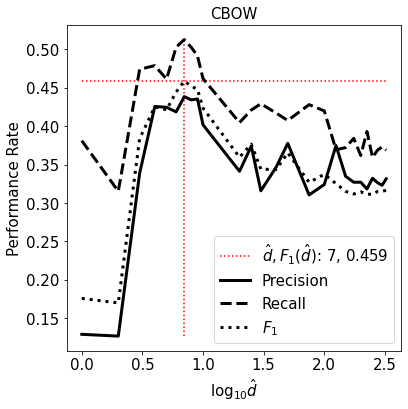

In [ ]:
k = 5; gamma = 0; space = False
print('building TDM...')
TDM, type_index = make_TDM([x['text'] for x in newstweet], 
                           space = space)
print('building CoM...')
CoM, type_index = make_CoM([x['text'] for x in newstweet], 
                           k = k, gamma = gamma, space = space)
print('evaluating CBOW...')
results = eval_cbow(TDM, CoM)

Interestingly, while $\gamma$-weighting doesn't boost overall performance, a potential higher-dimensional up-turn could suggest information recovery at larger context windows:

building TDM...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


building CoM...
evaluating CBOW...
evaluating d =  100
evaluating d =  200
evaluating d =  300


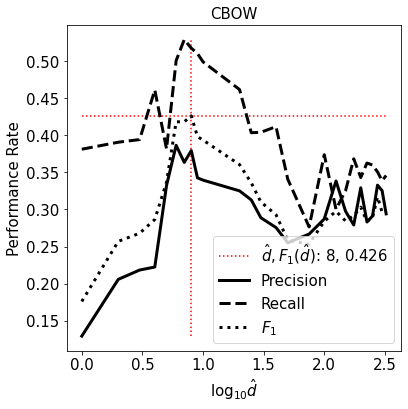

In [ ]:
k = 5; gamma = 1; space = False
print('building TDM...')
TDM, type_index = make_TDM([x['text'] for x in newstweet], 
                           space = space)
print('building CoM...')
CoM, type_index = make_CoM([x['text'] for x in newstweet], 
                           k = k, gamma = gamma, space = space)
print('evaluating CBOW...')
results = eval_cbow(TDM, CoM)

Here, because space's exclusion removes about half of the tokens from the stream, the $k=5$ context model is more comparable to the same model for $k=10$, _with space_ (since these two models will absorb the same non-space type co-ocurrences). Notably, when we look at our best model and _include_ the high-frequency statistics of space, the overall performance drops a little, but the metrics stabilize across a much larger dimensional range, not dropping off at all for larger values. 

This is _good_, because it means we can get a strong model, regardless of the dimensional hyperparameter. This is especially important when we want to apply to out of domain data, where we won't have the luxary of evaluating a hyperparameter's appropriateness.

building TDM...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


building CoM...
evaluating CBOW...
evaluating d =  100
evaluating d =  200
evaluating d =  300


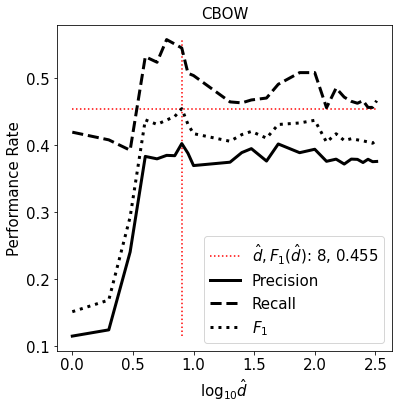

In [ ]:
k = 10; gamma = 1; space = True
print('building TDM...')
TDM, type_index = make_TDM([x['text'] for x in newstweet], 
                           space = space)
print('building CoM...')
CoM, type_index = make_CoM([x['text'] for x in newstweet], 
                           k = k, gamma = gamma, space = space)
print('evaluating CBOW...')
results = eval_cbow(TDM, CoM)

Expanding the context window _without space_ to $k = 10$ notably shows a boost, a bit more stability, but performance again drops as dimensions increase, making the dimensional hyperparameter's impact less reliable.

building TDM...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


building CoM...
evaluating CBOW...
evaluating d =  100
evaluating d =  200
evaluating d =  300


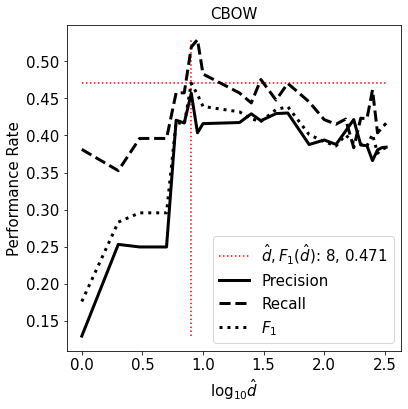

In [ ]:
k = 10; gamma = 0; space = False
print('building TDM...')
TDM, type_index = make_TDM([x['text'] for x in newstweet], 
                           space = space)
print('building CoM...')
CoM, type_index = make_CoM([x['text'] for x in newstweet], 
                           k = k, gamma = gamma, space = space)
print('evaluating CBOW...')
results = eval_cbow(TDM, CoM)

When we utilize the `gamma = 1` weighting scheme for a larger window (without space), again, we see decreased performance.

building TDM...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


building CoM...
evaluating CBOW...
evaluating d =  100
evaluating d =  200
evaluating d =  300


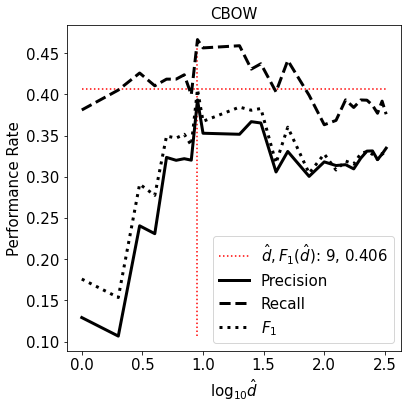

In [ ]:
k = 10; gamma = 1; space = False
print('building TDM...')
TDM, type_index = make_TDM([x['text'] for x in newstweet], 
                           space = space)
print('building CoM...')
CoM, type_index = make_CoM([x['text'] for x in newstweet], 
                           k = k, gamma = gamma, space = space)
print('evaluating CBOW...')
results = eval_cbow(TDM, CoM)

But racheting up the context window _with space_ to something comparable (`k = 20`) we see more improvement. Moreover, the model's learning curve appears to be smoothing out, and perhaps even increasing again for larger dimensions. Again, these are good signals to see that the models learned will be robustly useful, regardless of target-application data. Looking at it this way, we might consider this our best model.

building TDM...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


building CoM...
evaluating CBOW...
evaluating d =  100
evaluating d =  200
evaluating d =  300


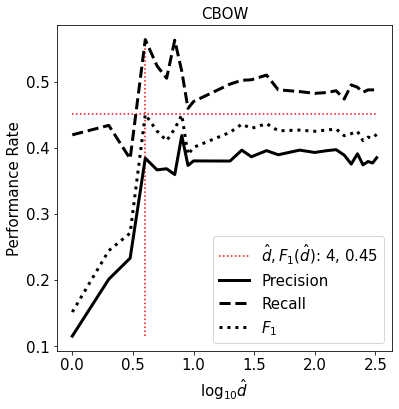

In [ ]:
k = 20; gamma = 1; space = True
print('building TDM...')
TDM, type_index = make_TDM([x['text'] for x in newstweet], 
                           space = space)
print('building CoM...')
CoM, type_index = make_CoM([x['text'] for x in newstweet], 
                           k = k, gamma = gamma, space = space)
print('evaluating CBOW...')
results = eval_cbow(TDM, CoM)

However, since we saw the _without space_ model perform better when no weighting was set, i.e. with `gamma = 0`, so it's just as well we complete exploration by parameterizing this way on our 'best' model (immediately above). 

Interestingly, it appears the with-space models also don't benefit from `gamma = 1`, i.e. from weighting. In theory, the `gamma` weighting should make it possible to accept variation from larger context windows, but we see it does here anyway, 'without' `gamma`. Likewise, we can see that the more distant information is steadily recovered for the higher-dimensional models, with a $50$-dimensional model finally turning up best. 

We must juxtapose this with the performance that ocurrs _without_ space, where higher-dimensional models show clear performance drops, despite slightly-better overall 'best' runs. This could lend credibility to the theory that those statistics are over-fit to less-articulated information. In truth, the with-space model has access to almost twice as much data (tokens), which could provide a lot of subtle cues to prediction, especially via the semantic features. Regardless, this then might become our overall 'best' reliable model from the experiment. As we'll see in the first few asignments, retaining space in our analysis can produce highly-articulate NLP systems that can even operate complex, well-spaced syntax.

building TDM...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


building CoM...
evaluating CBOW...
evaluating d =  100
evaluating d =  200
evaluating d =  300


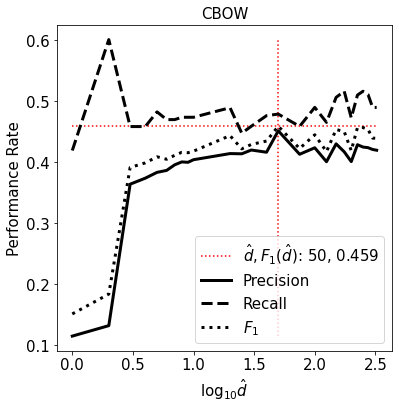

In [ ]:
k = 20; gamma = 0; space = True
print('building TDM...')
TDM, type_index = make_TDM([x['text'] for x in newstweet], 
                           space = space)
print('building CoM...')
CoM, type_index = make_CoM([x['text'] for x in newstweet], 
                           k = k, gamma = gamma, space = space)
print('evaluating CBOW...')
results = eval_cbow(TDM, CoM)